In [351]:
import pandas as pd

In [352]:
# Load cleaned charging data
charging_data: pd.DataFrame = pd.read_pickle('data/charging_modified.pkl')

# Drop columns with user_* prefix
charging_data = charging_data.drop(columns=charging_data.filter(regex='^user_', axis=1).columns)

# Print head
display(charging_data.head())

# Print row count
print(f'Row count: {charging_data.shape[0]}')

,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,siteID,spaceID,stationID,userID,weekday,fullyCharged,NoChargingTime,NoChargingTimeMinutes,NoChargingTimeHours,ChargingTime,ChargingTimeMinutes,ChargingTimeHours,kWhPerMinute,month,userRegistered
0,2018-04-25 11:08:04+00:00,2018-04-25 13:20:10+00:00,2018-04-25 13:21:10+00:00,7.932,2,CA-496,2-39-78-362,NaN,Wednesday,True,0 days 02:13:06,133.100000,2.218333,0 days 02:13:06,133.100000,2.218333,0.059594,4,False
1,2018-04-25 13:45:10+00:00,2018-04-26 00:56:16+00:00,2018-04-25 16:44:15+00:00,10.013,2,CA-319,2-39-95-27,NaN,Wednesday,True,0 days 02:59:05,179.083333,2.984722,0 days 02:59:05,179.083333,2.984722,0.055913,4,False
2,2018-04-25 13:45:50+00:00,2018-04-25 23:04:45+00:00,2018-04-25 14:51:44+00:00,5.257,2,CA-489,2-39-79-380,NaN,Wednesday,True,0 days 01:05:54,65.900000,1.098333,0 days 01:05:54,65.900000,1.098333,0.079772,4,False
3,2018-04-25 14:37:06+00:00,2018-04-25 23:55:34+00:00,2018-04-25 16:05:22+00:00,5.177,2,CA-327,2-39-79-379,NaN,Wednesday,True,0 days 01:28:16,88.266667,1.471111,0 days 01:28:16,88.266667,1.471111,0.058652,4,False
4,2018-04-25 14:40:34+00:00,2018-04-25 23:03:12+00:00,2018-04-25 17:40:30+00:00,10.119,2,CA-490,2-39-79-381,NaN,Wednesday,True,0 days 02:59:56,179.933333,2.998889,0 days 02:59:56,179.933333,2.998889,0.056237,4,False


Row count: 57513


# Preparing the data

## Basic data cleaning of null values

In [353]:
# Display null values
display(charging_data.isnull().sum())

# Drop columns with null values
# Dropping doneChargingTime is not an issue as this information is already encoded into ChargingTime and NoChargingTime
charging_data = charging_data.drop(columns=['userID', 'doneChargingTime'])
display(display(charging_data.isnull().sum()))

connectionTime               0
disconnectTime               0
doneChargingTime          2630
kWhDelivered                 0
siteID                       0
spaceID                      0
stationID                    0
userID                   16790
weekday                      0
fullyCharged                 0
NoChargingTime               0
NoChargingTimeMinutes        0
NoChargingTimeHours          0
ChargingTime                 0
ChargingTimeMinutes          0
ChargingTimeHours            0
kWhPerMinute                 0
month                        0
userRegistered               0
dtype: int64

connectionTime           0
disconnectTime           0
kWhDelivered             0
siteID                   0
spaceID                  0
stationID                0
weekday                  0
fullyCharged             0
NoChargingTime           0
NoChargingTimeMinutes    0
NoChargingTimeHours      0
ChargingTime             0
ChargingTimeMinutes      0
ChargingTimeHours        0
kWhPerMinute             0
month                    0
userRegistered           0
dtype: int64

None

## Convert columns to better fit clustering

In [354]:
display(charging_data.head())

,connectionTime,disconnectTime,kWhDelivered,siteID,spaceID,stationID,weekday,fullyCharged,NoChargingTime,NoChargingTimeMinutes,NoChargingTimeHours,ChargingTime,ChargingTimeMinutes,ChargingTimeHours,kWhPerMinute,month,userRegistered
0,2018-04-25 11:08:04+00:00,2018-04-25 13:20:10+00:00,7.932,2,CA-496,2-39-78-362,Wednesday,True,0 days 02:13:06,133.100000,2.218333,0 days 02:13:06,133.100000,2.218333,0.059594,4,False
1,2018-04-25 13:45:10+00:00,2018-04-26 00:56:16+00:00,10.013,2,CA-319,2-39-95-27,Wednesday,True,0 days 02:59:05,179.083333,2.984722,0 days 02:59:05,179.083333,2.984722,0.055913,4,False
2,2018-04-25 13:45:50+00:00,2018-04-25 23:04:45+00:00,5.257,2,CA-489,2-39-79-380,Wednesday,True,0 days 01:05:54,65.900000,1.098333,0 days 01:05:54,65.900000,1.098333,0.079772,4,False
3,2018-04-25 14:37:06+00:00,2018-04-25 23:55:34+00:00,5.177,2,CA-327,2-39-79-379,Wednesday,True,0 days 01:28:16,88.266667,1.471111,0 days 01:28:16,88.266667,1.471111,0.058652,4,False
4,2018-04-25 14:40:34+00:00,2018-04-25 23:03:12+00:00,10.119,2,CA-490,2-39-79-381,Wednesday,True,0 days 02:59:56,179.933333,2.998889,0 days 02:59:56,179.933333,2.998889,0.056237,4,False


### Expand date columns and add additional columns

In [355]:
# Split connectionTime and disconnectTime into date and time
def split_datetime_to_date_and_time(data: pd.DataFrame, col: str):
    data[col] = pd.to_datetime(data[col])
    data[col + 'Day'] = data[col].dt.day
    data[col + 'Month'] = data[col].dt.month
    data[col + 'Year'] = data[col].dt.year
    data[col + 'Hour'] = data[col].dt.hour
    data[col + 'Minute'] = data[col].dt.minute
    return data

charging_data = split_datetime_to_date_and_time(charging_data, 'connectionTime')
charging_data = split_datetime_to_date_and_time(charging_data, 'disconnectTime')

charging_data['ConnectionDurationInMinutes'] = (charging_data['disconnectTime'] - charging_data['connectionTime']).dt.total_seconds() / 60
charging_data['ConnectionDurationInHours'] = charging_data['ConnectionDurationInMinutes'] / 60

# Drop the original columns
full_charging_data = charging_data.copy()
charging_data = charging_data.drop(columns=['connectionTime', 'disconnectTime', 'month', 'weekday', 'ChargingTime', 'NoChargingTime', 'connectionTimeYear', 'disconnectTimeYear', 'kWhPerMinute'])
display(charging_data.head())

,kWhDelivered,siteID,spaceID,stationID,fullyCharged,NoChargingTimeMinutes,NoChargingTimeHours,ChargingTimeMinutes,ChargingTimeHours,userRegistered,connectionTimeDay,connectionTimeMonth,connectionTimeHour,connectionTimeMinute,disconnectTimeDay,disconnectTimeMonth,disconnectTimeHour,disconnectTimeMinute,ConnectionDurationInMinutes,ConnectionDurationInHours
0,7.932,2,CA-496,2-39-78-362,True,133.100000,2.218333,133.100000,2.218333,False,25,4,11,8,25,4,13,20,132.100000,2.201667
1,10.013,2,CA-319,2-39-95-27,True,179.083333,2.984722,179.083333,2.984722,False,25,4,13,45,26,4,0,56,671.100000,11.185000
2,5.257,2,CA-489,2-39-79-380,True,65.900000,1.098333,65.900000,1.098333,False,25,4,13,45,25,4,23,4,558.916667,9.315278
3,5.177,2,CA-327,2-39-79-379,True,88.266667,1.471111,88.266667,1.471111,False,25,4,14,37,25,4,23,55,558.466667,9.307778
4,10.119,2,CA-490,2-39-79-381,True,179.933333,2.998889,179.933333,2.998889,False,25,4,14,40,25,4,23,3,502.633333,8.377222


In [356]:
# spaceID and stationID are irrelevant for clustering, as users can just use another spot if one is occupied
charging_data = charging_data.drop(columns=['spaceID', 'stationID'])
display(charging_data.head())

,kWhDelivered,siteID,fullyCharged,NoChargingTimeMinutes,NoChargingTimeHours,ChargingTimeMinutes,ChargingTimeHours,userRegistered,connectionTimeDay,connectionTimeMonth,connectionTimeHour,connectionTimeMinute,disconnectTimeDay,disconnectTimeMonth,disconnectTimeHour,disconnectTimeMinute,ConnectionDurationInMinutes,ConnectionDurationInHours
0,7.932,2,True,133.100000,2.218333,133.100000,2.218333,False,25,4,11,8,25,4,13,20,132.100000,2.201667
1,10.013,2,True,179.083333,2.984722,179.083333,2.984722,False,25,4,13,45,26,4,0,56,671.100000,11.185000
2,5.257,2,True,65.900000,1.098333,65.900000,1.098333,False,25,4,13,45,25,4,23,4,558.916667,9.315278
3,5.177,2,True,88.266667,1.471111,88.266667,1.471111,False,25,4,14,37,25,4,23,55,558.466667,9.307778
4,10.119,2,True,179.933333,2.998889,179.933333,2.998889,False,25,4,14,40,25,4,23,3,502.633333,8.377222


### One hot encode nominal columns

In [357]:
# One hot encode nominal columns
# this increases the dimensionality of the data (labels encoding would imply an ordinal relationship between the values)
charging_data = pd.get_dummies(charging_data, columns=['siteID'])
display(charging_data.head())

,kWhDelivered,fullyCharged,NoChargingTimeMinutes,NoChargingTimeHours,ChargingTimeMinutes,ChargingTimeHours,userRegistered,connectionTimeDay,connectionTimeMonth,connectionTimeHour,connectionTimeMinute,disconnectTimeDay,disconnectTimeMonth,disconnectTimeHour,disconnectTimeMinute,ConnectionDurationInMinutes,ConnectionDurationInHours,siteID_1,siteID_2
0,7.932,True,133.100000,2.218333,133.100000,2.218333,False,25,4,11,8,25,4,13,20,132.100000,2.201667,False,True
1,10.013,True,179.083333,2.984722,179.083333,2.984722,False,25,4,13,45,26,4,0,56,671.100000,11.185000,False,True
2,5.257,True,65.900000,1.098333,65.900000,1.098333,False,25,4,13,45,25,4,23,4,558.916667,9.315278,False,True
3,5.177,True,88.266667,1.471111,88.266667,1.471111,False,25,4,14,37,25,4,23,55,558.466667,9.307778,False,True
4,10.119,True,179.933333,2.998889,179.933333,2.998889,False,25,4,14,40,25,4,23,3,502.633333,8.377222,False,True


## Cyclic encoding of time

In [358]:
# Taken from https://medium.com/@TheDataSciencePro/revolutionizing-predictive-analytics-unveiling-the-power-of-cyclical-feature-encoding-78c765ffc9bf
def encode_cyclical_feature(data: pd.DataFrame, feature: str, period: int):
    """
    Encode a cyclical feature into two dimensions (sin and cos components).
    
    Parameters:
    - data: DataFrame containing the dataset.
    - feature: Name of the cyclical feature column.
    - period: The period of the cyclical pattern.
    """
    import numpy as np
    from sklearn.preprocessing import StandardScaler
    
    scaled_feature = StandardScaler().fit_transform(data[[feature]])
    
    data[feature + '_sin'] = np.sin(2 * np.pi * scaled_feature / period)
    data[feature + '_cos'] = np.cos(2 * np.pi * scaled_feature / period)

def encode_datetime_to_cyclic(data: pd.DataFrame, feature: str):
    suffixes: list[tuple[str, int]] = [('Month', 12), ('Day', 31), ('Hour', 24), ('Minute', 60)]
    for suffix, period in suffixes:
        # Check if column exists
        column_name = feature + suffix
        if column_name in data.columns:
            encode_cyclical_feature(data, column_name, period)    

# Create a copy
prepared_data = charging_data.copy()

# Encode the time components to cyclic
encode_datetime_to_cyclic(prepared_data, 'connectionTime')
encode_datetime_to_cyclic(prepared_data, 'disconnectTimeMonth')

display(prepared_data.head())

,kWhDelivered,fullyCharged,NoChargingTimeMinutes,NoChargingTimeHours,ChargingTimeMinutes,ChargingTimeHours,userRegistered,connectionTimeDay,connectionTimeMonth,connectionTimeHour,...,siteID_1,siteID_2,connectionTimeMonth_sin,connectionTimeMonth_cos,connectionTimeDay_sin,connectionTimeDay_cos,connectionTimeHour_sin,connectionTimeHour_cos,connectionTimeMinute_sin,connectionTimeMinute_cos
0,7.932,True,133.100000,2.218333,133.100000,2.218333,False,25,4,11,...,False,True,-0.423002,0.906129,0.2149,0.976636,-0.165512,0.986208,-0.130026,0.991511
1,10.013,True,179.083333,2.984722,179.083333,2.984722,False,25,4,13,...,False,True,-0.423002,0.906129,0.2149,0.976636,-0.072246,0.997387,0.093965,0.995576
2,5.257,True,65.900000,1.098333,65.900000,1.098333,False,25,4,13,...,False,True,-0.423002,0.906129,0.2149,0.976636,-0.072246,0.997387,0.093965,0.995576
3,5.177,True,88.266667,1.471111,88.266667,1.471111,False,25,4,14,...,False,True,-0.423002,0.906129,0.2149,0.976636,-0.025322,0.999679,0.045548,0.998962
4,10.119,True,179.933333,2.998889,179.933333,2.998889,False,25,4,14,...,False,True,-0.423002,0.906129,0.2149,0.976636,-0.025322,0.999679,0.063723,0.997968


## Methods for clustering

In [359]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

random_state = 42
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer


def kmean(data, n_clusters):
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=random_state)
    labels = kmeans.fit_predict(data)
    return labels, kmeans

def pca(data):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)
    return pca_result

def pca_based_kmean(data, n_clusters):
    pca_result = pca(data)
    labels, kmeans = kmean(pca_result, n_clusters)
    return labels, kmeans, pca_result

def plot_kmeans(data: pd.DataFrame, labels):
    u_labels = np.unique(labels)
    for i in u_labels:
        plt.scatter(data[labels == i, 0], data[labels == i, 1], label=f'Cluster {i}')
    plt.legend()
    plt.show() 
    
def perform_kmeans_and_plot(data: pd.DataFrame, n_clusters: int):
    labels, kmeans, pca_result = pca_based_kmean(data, n_clusters)
    plot_kmeans(pca_result, labels)
    return labels, kmeans, pca_result

def scale_df(data: pd.DataFrame) -> pd.DataFrame:
    # Get cyclic columns, i.e., ending _sin or _cos
    cyclic_columns = [col for col in data.columns if col.endswith('_sin') or col.endswith('_cos')] + ['siteID_1', 'siteID_2', 'userRegistered']
    
    # Select columns to scale (excluding cyclic columns)
    columns_to_scale = data.columns.difference(cyclic_columns)
    
    # Create a MinMaxScaler object
    scaler = MinMaxScaler()
    
    # Scale selected columns
    df_scaled = data.copy()  # Make a copy of the original DataFrame
    df_scaled[columns_to_scale] = scaler.fit_transform(df_scaled[columns_to_scale])
    return df_scaled

def visualize_elbow(data, min_clusters=2, max_clusters=10, scale=True):
    input_data = scale_df(data) if scale else data
    display(input_data.head())
    kelbow_visualizer(KMeans(random_state=random_state, n_init='auto'), input_data, k=(min_clusters, max_clusters))
    
def normalize_and_cluster(data: pd.DataFrame, n_clusters: int) -> np.ndarray:
    input_data = scale_df(data)
    labels, kmeans, pca_result = perform_kmeans_and_plot(input_data, n_clusters)
    return labels

# Clustering

In [360]:
prepared_data.head()
# Check for null values

,kWhDelivered,fullyCharged,NoChargingTimeMinutes,NoChargingTimeHours,ChargingTimeMinutes,ChargingTimeHours,userRegistered,connectionTimeDay,connectionTimeMonth,connectionTimeHour,...,siteID_1,siteID_2,connectionTimeMonth_sin,connectionTimeMonth_cos,connectionTimeDay_sin,connectionTimeDay_cos,connectionTimeHour_sin,connectionTimeHour_cos,connectionTimeMinute_sin,connectionTimeMinute_cos
0,7.932,True,133.100000,2.218333,133.100000,2.218333,False,25,4,11,...,False,True,-0.423002,0.906129,0.2149,0.976636,-0.165512,0.986208,-0.130026,0.991511
1,10.013,True,179.083333,2.984722,179.083333,2.984722,False,25,4,13,...,False,True,-0.423002,0.906129,0.2149,0.976636,-0.072246,0.997387,0.093965,0.995576
2,5.257,True,65.900000,1.098333,65.900000,1.098333,False,25,4,13,...,False,True,-0.423002,0.906129,0.2149,0.976636,-0.072246,0.997387,0.093965,0.995576
3,5.177,True,88.266667,1.471111,88.266667,1.471111,False,25,4,14,...,False,True,-0.423002,0.906129,0.2149,0.976636,-0.025322,0.999679,0.045548,0.998962
4,10.119,True,179.933333,2.998889,179.933333,2.998889,False,25,4,14,...,False,True,-0.423002,0.906129,0.2149,0.976636,-0.025322,0.999679,0.063723,0.997968


## Cluster based all columns

,kWhDelivered,fullyCharged,NoChargingTimeMinutes,NoChargingTimeHours,ChargingTimeMinutes,ChargingTimeHours,userRegistered,connectionTimeDay,connectionTimeMonth,connectionTimeHour,...,siteID_1,siteID_2,connectionTimeMonth_sin,connectionTimeMonth_cos,connectionTimeDay_sin,connectionTimeDay_cos,connectionTimeHour_sin,connectionTimeHour_cos,connectionTimeMinute_sin,connectionTimeMinute_cos
0,0.099044,1.0,0.011091,0.011091,0.011091,0.011091,False,0.8,0.272727,0.478261,...,False,True,-0.423002,0.906129,0.2149,0.976636,-0.165512,0.986208,-0.130026,0.991511
1,0.126781,1.0,0.014922,0.014922,0.014922,0.014922,False,0.8,0.272727,0.565217,...,False,True,-0.423002,0.906129,0.2149,0.976636,-0.072246,0.997387,0.093965,0.995576
2,0.063391,1.0,0.005491,0.005491,0.005491,0.005491,False,0.8,0.272727,0.565217,...,False,True,-0.423002,0.906129,0.2149,0.976636,-0.072246,0.997387,0.093965,0.995576
3,0.062324,1.0,0.007355,0.007355,0.007355,0.007355,False,0.8,0.272727,0.608696,...,False,True,-0.423002,0.906129,0.2149,0.976636,-0.025322,0.999679,0.045548,0.998962
4,0.128194,1.0,0.014993,0.014993,0.014993,0.014993,False,0.8,0.272727,0.608696,...,False,True,-0.423002,0.906129,0.2149,0.976636,-0.025322,0.999679,0.063723,0.997968


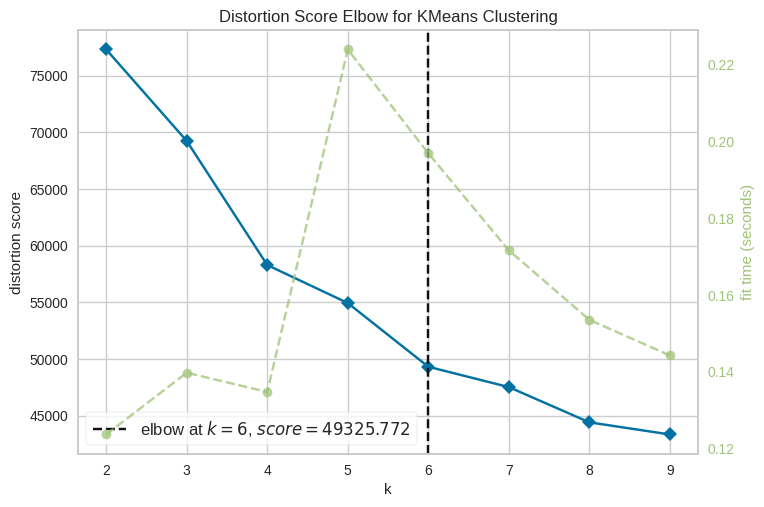

In [361]:
df_all_columns = prepared_data.copy()

# Drop normal non-cyclic columns for connectionTime and disconnectTime
df_all_columns = df_all_columns.drop(columns=['connectionTimeMonth', 'connectionTimeDay', 'connectionTimeHour', 'connectionTimeMinute', 'disconnectTimeMonth', 'disconnectTimeDay', 'disconnectTimeHour', 'disconnectTimeMinute'])
visualize_elbow(prepared_data, 2, 10, True)

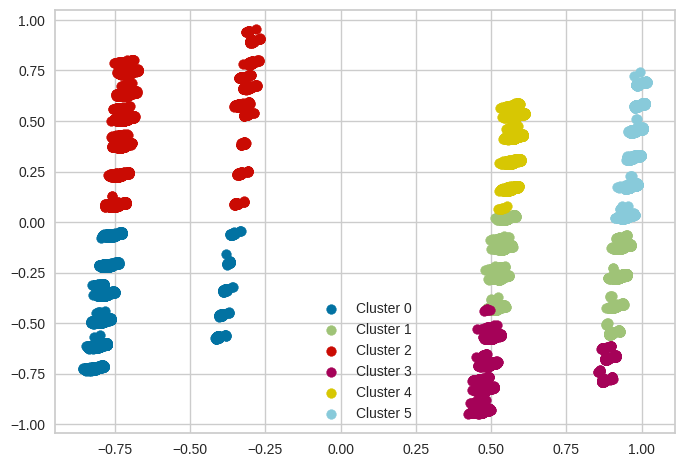

In [362]:
labels = normalize_and_cluster(df_all_columns, 6)

In [366]:
# Append labels to the original data
full_charging_data_labeled = full_charging_data.copy()
full_charging_data_labeled['cluster'] = labels

# With only ours representation we can't display that the session is going over midnight, so we make disconnectTimeHour equal to connectionTimeHour + ConnectionDurationInHours
full_charging_data_labeled['disconnectTimeHour'] = (full_charging_data_labeled['connectionTimeHour'] + full_charging_data_labeled['ConnectionDurationInHours']).astype(int)

# Restrict to interesting columns
full_charging_data_labeled = full_charging_data_labeled[['connectionTimeHour', 'disconnectTimeHour', 'kWhDelivered', 'ConnectionDurationInHours', 'NoChargingTimeHours', 'cluster']]

# Group by cluster and describe
full_charging_data_labeled.groupby('cluster').describe()

connectionTimeHour                                                    \
                     count       mean       std  min   25%   50%   75%   max   
cluster                                                                        
0                  13107.0  14.896544  4.465116  0.0  13.0  14.0  16.0  23.0   
1                   7657.0  14.133211  6.328397  0.0  14.0  16.0  18.0  23.0   
2                  16058.0  14.979823  4.271034  0.0  13.0  14.0  17.0  23.0   
3                   5661.0  15.228935  5.980848  0.0  15.0  17.0  18.0  23.0   
4                   5301.0  14.717035  6.183263  0.0  15.0  16.0  18.0  23.0   
5                   9729.0  13.150684  7.112243  0.0   6.0  15.0  18.0  23.0   

        disconnectTimeHour             ... ConnectionDurationInHours  \
                     count       mean  ...                       75%   
cluster                                ...                             
0                  13107.0  21.500420  ...                  9.704167   
1                   7657.0  19.851900  ...                  8.758056   
2                  16058.0  21.478515  ...                  9.639444   
3                   5661.0  20.960784  ...                  8.722222   
4                   5301.0  20.481985  ...                  8.810556   
5                   9729.0  18.009251  ...                  8.290833   

                    NoChargingTimeHours                                     \
                max               count      mean       std  min       25%   
cluster                                                                      
0         48.320556             13107.0  4.055862  2.452772  0.0  2.241389   
1        150.216389              7657.0  3.002733  3.729926  0.0  1.072778   
2         58.740000             16058.0  3.741267  2.675919  0.0  1.867569   
3        214.321944              5661.0  2.812704  3.921204  0.0  1.175278   
4        158.082778              5301.0  2.986166  2.767005  0.0  1.266111   
5        245.269167              9729.0  3.010240  3.391148  0.0  1.065556   

                                         
              50%       75%         max  
cluster                                  
0        3.598056  5.373194   25.280556  
1        2.061667  3.968889  150.232778  
2        3.301528  5.169375   18.523889  
3        1.965833  3.651667  200.015833  
4        2.112778  3.983333   79.863056  
5        2.076389  3.958056  104.428333  

[6 rows x 40 columns]

## Cluster with temperature

In [ ]:
weather_df = pd.read_pickle('data/weather_modified.pkl')
weather_df.head()